<a href="https://colab.research.google.com/github/sudhankandel/facemask-Detection/blob/master/face_mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d wobotintelligence/face-mask-detection-dataset
!rm kaggle.json

Saving kaggle.json to kaggle.json
 99% 2.48G/2.50G [00:44<00:00, 69.2MB/s]
100% 2.50G/2.50G [00:44<00:00, 60.4MB/s]


In [ ]:
!unzip face-mask-detection-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Medical mask/Medical mask/Medical Mask/images/1092.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1093.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1094.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1095.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1096.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1097.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1098.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1099.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1101.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1102.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1103.png  
  inflating: Medical mask/Medical mask/Medical Mask/images/1104.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1105.jpg  
  inflating: Medical mask/Medical mask/

In [ ]:
!rm -rf sample_data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import pprint as pp
import pandas as pd
import cv2
import random

In [ ]:
BASE_DIR = 'Medical mask/Medical mask/Medical Mask'
IMAGE_DIR = os.path.join(BASE_DIR, 'images')
ANNOTATIONS_DIR = os.path.join(BASE_DIR, 'annotations')

In [ ]:
for file in os.listdir(ANNOTATIONS_DIR):
  with open(os.path.join(ANNOTATIONS_DIR, file), 'r') as f:
    data = json.load(f)
    pp.pprint(data)
    break

{'Annotations': [{'Attributes': {},
                  'BoundingBox': [113, 40, 402, 461],
                  'Confidence': 1,
                  'ID': 18349892904704788,
                  'classname': 'face_with_mask',
                  'isProtected': False},
                 {'Attributes': {},
                  'BoundingBox': [154, 305, 376, 454],
                  'Confidence': 1,
                  'ID': 673462846890452608,
                  'classname': 'mask_colorful',
                  'isProtected': False}],
 'FileName': '3973.png',
 'NumOfAnno': 2}


In [ ]:
data=pd.read_csv('train.csv')
data.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [ ]:
faces_with_mask=(data[data['classname']=='face_with_mask']).values.tolist()
faces_without_mask=(data[data['classname']=='face_no_mask']).values.tolist()

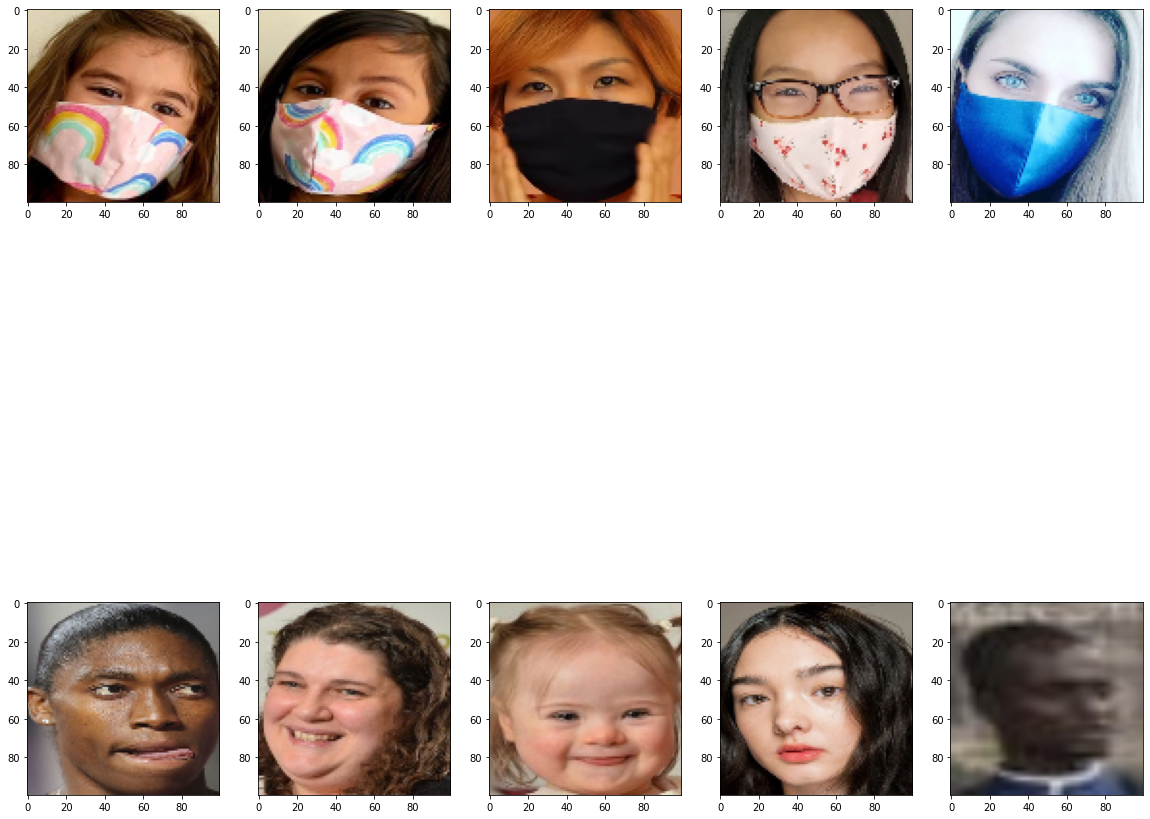

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(20, 20))

for i, face in enumerate(faces_with_mask[:5]):
  image = cv2.cvtColor(cv2.imread(os.path.join(IMAGE_DIR, face[0])), cv2.COLOR_BGR2RGB)
  start = int(face[1]), int(face[2])
  end = int(face[3]), int(face[4])
  image = image[start[1]:end[1], start[0]:end[0]]
  image = cv2.resize(image, (100, 100))
  ax[0, i].imshow(image)

for i, face in enumerate(faces_without_mask[:5]):
  image = cv2.cvtColor(cv2.imread(os.path.join(IMAGE_DIR, face[0])), cv2.COLOR_BGR2RGB)
  start = int(face[1]), int(face[2])
  end = int(face[3]), int(face[4])
  image = image[start[1]:end[1], start[0]:end[0]]
  image = cv2.resize(image, (100, 100))
  ax[1, i].imshow(image)
fig.show()

In [ ]:
X = []
y = []

for i, cat in enumerate((faces_without_mask, faces_with_mask)):
  for f in cat:
    image = cv2.cvtColor(cv2.imread(os.path.join(IMAGE_DIR, f[0])), cv2.COLOR_BGR2RGB)
    start = int(f[1]), int(f[2])
    end = int(f[3]), int(f[4])
    image = image[start[1]:end[1], start[0]:end[0]]
    image = cv2.resize(image, (100, 100))
    X.append(image)
    y.append(i)

print(len(X))
print(len(y))

5749
5749


In [ ]:
# Splitting the data for training and testing
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import preprocess_input

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

print(len(X_train), len(X_test))
X_train = np.array(X_train, dtype='float32')
y_train = np.array(y_train)
X_test = np.array(X_test, dtype='float32')
y_test = np.array(y_test)

5174 575


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam


base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(100, 100, 3)), classes=1)

new_model = base_model.output
new_model = Flatten()(new_model)
new_model = Dense(256, activation='relu')(new_model)
new_model = Dense(1, activation='sigmoid')(new_model)

for layer in base_model.layers:
  layer.trainable = False

model = Model(inputs=base_model.input, outputs=new_model)
opt = Adam(lr=1e-4)
model.compile(loss='binary_crossentropy' ,optimizer=opt, metrics=['accuracy'])
model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_______________________________________________________

In [ ]:
!pip install livelossplot

In [ ]:
from livelossplot import PlotLossesKeras
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

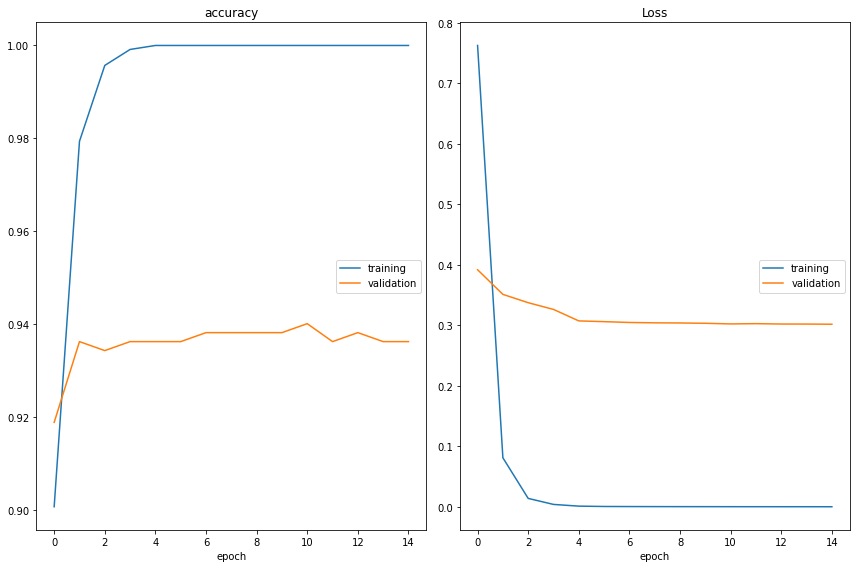

accuracy
	training         	 (min:    0.901, max:    1.000, cur:    1.000)
	validation       	 (min:    0.919, max:    0.940, cur:    0.936)
Loss
	training         	 (min:    0.000, max:    0.763, cur:    0.000)
	validation       	 (min:    0.302, max:    0.392, cur:    0.302)
146/146 [==============================] - 12s 79ms/step - loss: 1.5330e-04 - accuracy: 1.0000 - val_loss: 0.3018 - val_accuracy: 0.9363


In [ ]:
EPOCHS=15
reduce_lr=ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,min_lr=0.00001,mode='auto')
callback=[PlotLossesKeras(),reduce_lr]

history = model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.1
                    ,callbacks=callback)

In [ ]:
model.save("mask_detector.model", save_format="h5")

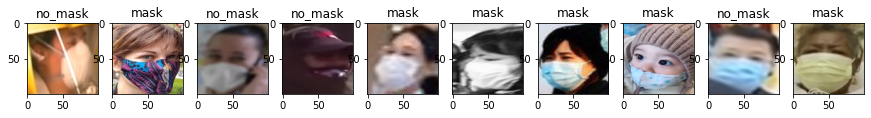

In [ ]:
# from google.colab.patches import cv2_imshow
import tensorflow as tf 

cat = ('no_mask', 'mask')
fig, ax = plt.subplots(1, 10, figsize=(15, 15))

for i in range(10):
  image = random.choice(X_test)
  predictions = model.predict(image.reshape(-1, 100, 100, 3))
  title = cat[int(predictions[0][0])]

  ax[i].imshow(image.astype('uint32'))
  ax[i].title.set_text(title)

fig.show()